# **Ecuación de Cahn-Hilliar**

---
Entrenamiento de un modelo FNO para la ecuación de Cahn-Hilliar.

In [2]:
# Importar librerías
import sys
import torch
import numpy as np
import matplotlib.pyplot as plt

from matplotlib.animation import FuncAnimation
from matplotlib import animation
from IPython.display import HTML

from neuralop.models import FNO
from neuralop import Trainer
from neuralop.training import AdamW
from neuralop.utils import count_model_params
from neuralop import LpLoss, H1Loss
from neuralop.data.datasets.pt_dataset import PTDataset

from torch.utils.data import DataLoader

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

## **Carga de Datos y Definición del Modelo**

In [3]:
# Carga de Datos
dataset = PTDataset(
    root_dir="../data/cahn_hilliard_data",
    dataset_name="cahn_hilliard",
    n_train=1024,
    n_tests=[192],
    batch_size=32,
    test_batch_sizes=[32],
    train_resolution=64,
    test_resolutions=[64],
)

train_loader = DataLoader(dataset.train_db, batch_size=32, shuffle=True)
test_loaders = {res: DataLoader(db, batch_size=32, shuffle=False) for res, db in dataset.test_dbs.items()}

data_processor = dataset.data_processor.to(device)

print("Train dataset size:", len(dataset.train_db))
print("Test datasets sizes:", {res: len(db) for res, db in dataset.test_dbs.items()})


Loading test db for resolution 64 with 192 samples 
Train dataset size: 1024
Test datasets sizes: {64: 192}


In [4]:
# Definición del Modelo
model = FNO(n_modes=(48, 48),
             in_channels=1, 
             out_channels=1,
             hidden_channels=32, 
             projection_channel_ratio=2)
model = model.to(device)

# Cantidad de Parámetros
n_params = count_model_params(model)
print(f'\nThe Model has {n_params} parameters.')
sys.stdout.flush()


The Model has 9843553 parameters.


In [5]:
# Definición del Optimizador
optimizer = AdamW(model.parameters(), 
                  lr=8e-3, 
                  weight_decay=1e-4)

scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, 
                                                       T_max=30)

In [6]:
# Definir las Funciones Pérdida
l2loss = LpLoss(d=2, p=2)
h1loss = H1Loss(d=2)

train_loss = h1loss
eval_losses={'h1': h1loss, 'l2': l2loss}

In [7]:
# Resumen del Modelo
print('\n### MODEL ###\n', model)
print('\n### OPTIMIZER ###\n', optimizer)
print('\n### SCHEDULER ###\n', scheduler)
print('\n### LOSSES ###')
print(f'\n * Train: {train_loss}')
print(f'\n * Test: {eval_losses}')
sys.stdout.flush()


### MODEL ###
 FNO(
  (positional_embedding): GridEmbeddingND()
  (fno_blocks): FNOBlocks(
    (convs): ModuleList(
      (0-3): 4 x SpectralConv(
        (weight): DenseTensor(shape=torch.Size([32, 32, 48, 25]), rank=None)
      )
    )
    (fno_skips): ModuleList(
      (0-3): 4 x Flattened1dConv(
        (conv): Conv1d(32, 32, kernel_size=(1,), stride=(1,), bias=False)
      )
    )
    (channel_mlp): ModuleList(
      (0-3): 4 x ChannelMLP(
        (fcs): ModuleList(
          (0): Conv1d(32, 16, kernel_size=(1,), stride=(1,))
          (1): Conv1d(16, 32, kernel_size=(1,), stride=(1,))
        )
      )
    )
    (channel_mlp_skips): ModuleList(
      (0-3): 4 x SoftGating()
    )
  )
  (lifting): ChannelMLP(
    (fcs): ModuleList(
      (0): Conv1d(3, 64, kernel_size=(1,), stride=(1,))
      (1): Conv1d(64, 32, kernel_size=(1,), stride=(1,))
    )
  )
  (projection): ChannelMLP(
    (fcs): ModuleList(
      (0): Conv1d(32, 64, kernel_size=(1,), stride=(1,))
      (1): Conv1d(64,

## **Entrenamiento**

In [8]:
trainer = Trainer(model=model, 
                  n_epochs=20,
                  device=device,
                  data_processor=data_processor,
                  wandb_log=False,
                  eval_interval=4,
                  use_distributed=False,
                  verbose=True)

In [9]:
trainer.train(train_loader=train_loader,
              test_loaders=test_loaders,
              optimizer=optimizer,
              scheduler=scheduler, 
              regularizer=False, 
              training_loss=train_loss,
              eval_losses=eval_losses)

Training on 1024 samples
Testing on [192] samples         on resolutions [64].
Raw outputs of shape torch.Size([32, 1, 64, 64])
[0] time=36.29, avg_loss=0.7801, train_err=24.9644
Eval: 64_h1=0.6128, 64_l2=0.5785
[4] time=42.19, avg_loss=0.3132, train_err=10.0227
Eval: 64_h1=0.4227, 64_l2=0.3594
[8] time=32.71, avg_loss=0.1974, train_err=6.3158
Eval: 64_h1=0.4111, 64_l2=0.3466
[12] time=42.88, avg_loss=0.1367, train_err=4.3730
Eval: 64_h1=0.4017, 64_l2=0.3360
[16] time=33.37, avg_loss=0.0982, train_err=3.1411
Eval: 64_h1=0.4031, 64_l2=0.3362


{'train_err': 2.4858496338129044,
 'avg_loss': 0.07768280105665326,
 'avg_lasso_loss': None,
 'epoch_train_time': 32.31885749999492}

## **Visualización**

Para ver una comparación entre las soluciones reales y las obtenidas con el modelo se usa el siguiente código. Primero se seleccionan tres índices aleatorios para los cuales se presenta la condición incial, el *ground_truth* (solución real) y el output de la red (predicción).

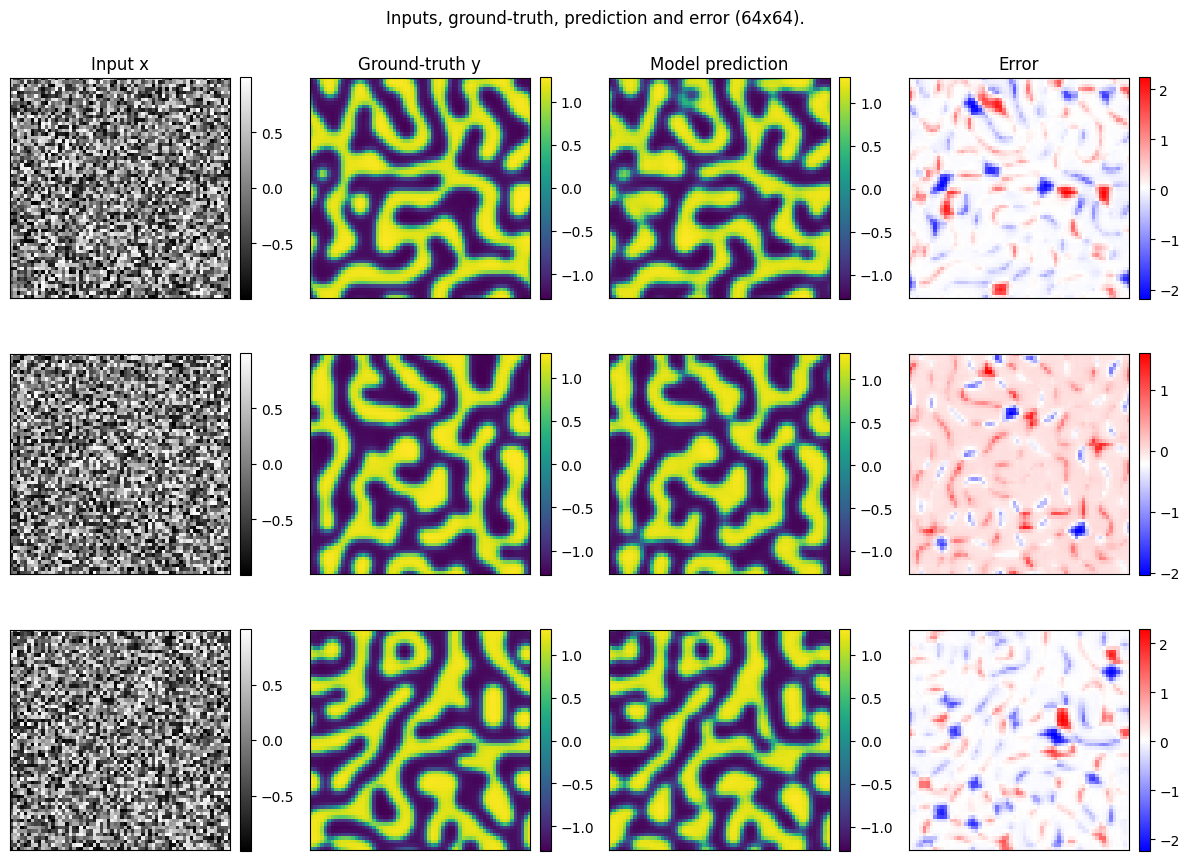

In [17]:
test_samples = test_loaders[64].dataset

selected_indices = np.random.randint(0, len(test_samples), size=3)
fig = plt.figure(figsize=(12, 9))

for plot_idx, index in enumerate(selected_indices):
    data = test_samples[index]
    data = data_processor.preprocess(data, batched=False)

    x = data['x']
    y = data['y']
    out = model(x.unsqueeze(0)).squeeze().detach().numpy() 
    gt = y.squeeze().numpy()

    error = out - gt

    # Columna 1: Input
    ax = fig.add_subplot(3, 4, plot_idx * 4 + 1)
    im0 = ax.imshow(x[0], cmap='gray')
    if plot_idx == 0:
        ax.set_title('Input x')
    plt.xticks([], [])
    plt.yticks([], [])
    fig.colorbar(im0, ax=ax, fraction=0.046, pad=0.04)

    # Columna 2: Ground-truth
    ax = fig.add_subplot(3, 4, plot_idx * 4 + 2)
    im1 = ax.imshow(gt)
    if plot_idx == 0:
        ax.set_title('Ground-truth y')
    plt.xticks([], [])
    plt.yticks([], [])
    fig.colorbar(im1, ax=ax, fraction=0.046, pad=0.04)

    # Columna 3: Predicción
    ax = fig.add_subplot(3, 4, plot_idx * 4 + 3)
    im2 = ax.imshow(out)
    if plot_idx == 0:
        ax.set_title('Model prediction')
    plt.xticks([], [])
    plt.yticks([], [])
    fig.colorbar(im2, ax=ax, fraction=0.046, pad=0.04)

    # Columna 4: Error (predicción - ground truth)
    ax = fig.add_subplot(3, 4, plot_idx * 4 + 4)
    im3 = ax.imshow(error, cmap='bwr')
    if plot_idx == 0:
        ax.set_title('Error')
    plt.xticks([], [])
    plt.yticks([], [])
    fig.colorbar(im3, ax=ax, fraction=0.046, pad=0.04)

fig.suptitle('Inputs, ground-truth, prediction and error (64x64).', y=0.98)
plt.tight_layout()
plt.show()